In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_style("dark")

In [13]:
def plot_distribution_with_table(df: pd.DataFrame, x: str, y: str, title: str = "Distribution Plot") -> None:
    """
    Plots a count distribution of x grouped by y, and prints a summary table
    with counts and percentages for each y category.

    Args:
    - df (pd.DataFrame): The input dataframe
    - x (str): Column representing the measurement (e.g., 'tickets')
    - y (str): Categorical column to group by (e.g., 'queue')
    - title (str): Plot title (optional). If None, a default title is used.
    """

    # Compute counts and percentages
    y_counts = df[y].value_counts()
    y_percent = df[y].value_counts(normalize=True) * 100

    # Combine into summary table
    summary_table = pd.DataFrame({
        f'# of {x}': y_counts,
        'Percentage of Total (%)': y_percent.round(2)
    })

    # Plot countplot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=y, order=y_counts.index)
    plt.title(f'{x} Distribution by {y.title()}')
    plt.xlabel(f'# of {x}')
    plt.ylabel(y.title())
    plt.tight_layout()
    plt.show()

    # Print summary table
    print(summary_table)

def plot_queue_heatmap(df: pd.DataFrame, x: str, y: str, title: str = "Heatmap Plot") -> None:
    """
    Plots a heatmap of ticket counts by queue and priority level.

    Args:
    - ct (pd.DataFrame): A crosstab or pivot table DataFrame with queues as rows and priority levels as columns.
    - title (str): Title of the plot.
    """
    ct = pd.crosstab(df[y], df[x])

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        ct,
        annot=True,
        fmt='d',
        cmap='coolwarm',
        cbar_kws={'label': f'{x} Count'}
    )
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

def plot_text_length_by_queue(
    df: pd.DataFrame,
    text_col: str,
    queue_col: str,
    bins: int = 30,
    title: str = "Histogram Plot"
) -> None:
    """
    Visualizes distribution of text length (word or character count) by queue.

    Args:
        df (pd.DataFrame): Input DataFrame.
        text_col (str): Column name containing the text.
        queue_col (str): Column name representing the queue.
        bins (int): Number of histogram bins.
        title (str): Optional plot title.
    """
    df = df.copy()
    df["text_length"] = df[text_col].fillna("").str.split().apply(len)

    queues = df[queue_col].dropna().unique()
    n = len(queues)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, queue in enumerate(queues):
        sns.histplot(
            df[df[queue_col] == queue]["text_length"],
            bins=bins,
            ax=axes[idx],
            kde=False,
            color="skyblue"
        )
        axes[idx].set_title(queue)
        axes[idx].set_xlabel("Word Count")
        axes[idx].set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(len(queues), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def top_keywords_per_queue(
    df: pd.DataFrame,
    text_col: str,
    queue_col: str,
    method: str = "tfidf",
    top_n: int = 10
) -> pd.DataFrame:
    """
    Returns a ranked list of top keywords per queue.

    Args:
        df (pd.DataFrame): Input DataFrame.
        text_col (str): Name of the text column.
        queue_col (str): Name of the queue/category column.
        method (str): 'tfidf' or 'count'.
        top_n (int): Number of top words to return per queue.

    Returns:
        pd.DataFrame: DataFrame with top keywords and scores per queue.
    """
    df = df[[queue_col, text_col]].dropna()

    results = []
    for queue in df[queue_col].unique():
        subset = df[df[queue_col] == queue]
        texts = subset[text_col].values

        if method == "tfidf":
            vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
        elif method == "count":
            vectorizer = CountVectorizer(stop_words="english", max_features=1000)
        else:
            raise ValueError("method must be 'tfidf' or 'count'")

        X = vectorizer.fit_transform(texts)
        scores = X.toarray().mean(axis=0)
        vocab = vectorizer.get_feature_names_out()
        word_scores = sorted(zip(vocab, scores), key=lambda x: -x[1])[:top_n]

        for word, score in word_scores:
            results.append({"queue": queue, "word": word, "score": score})

    return pd.DataFrame(results)

In [16]:
#load the data
raw_data = pd.read_csv("../data/raw/aa_dataset-tickets-multi-lang-5-2-50-version.csv")

#view target varible and sample of text data
print(raw_data['queue'].unique())
raw_data[["subject","body"]].sample(2)

['Technical Support' 'Returns and Exchanges' 'Billing and Payments'
 'Sales and Pre-Sales' 'Service Outages and Maintenance' 'Product Support'
 'IT Support' 'Customer Service' 'Human Resources' 'General Inquiry']


,subject,body
3549,Sichere Speicherung medizinischer Daten,Könnten Sie bitte eine Anleitung zu bewährten Verfahren für die Sicherung medizinischer Daten mit Symantec Endpoint Protection 14.3 bereitstellen?
27004,Required Assistance with API Integration,Can you furnish details on API integration and project management services?


From a previous notebook, I learned that the dataset contains mislabeled languages.

In [17]:
#combine subject + body into a single text field
raw_data["analysis_text"] = raw_data["subject"].fillna('') + " " + raw_data["body"].fillna('')

#use langdetect to find the true language
raw_data["detected_language"] = raw_data["analysis_text"].apply(lambda x: detect(x))

# Only keep English tickets for analysis -> We decided to focus on English tickets for this analysis because translation is resource-intensive
english_data = raw_data[raw_data['detected_language'] == 'en']

#### 1. Class Distribution Analysis
 - Queue Distribution: Bar Chart showing frequency of each queue
    - A check of imbalance
- Priority vs. Queue Crosstab: Heatmap of Priority Level by queue
    - Are high priority tickets more prevelant in certain queues


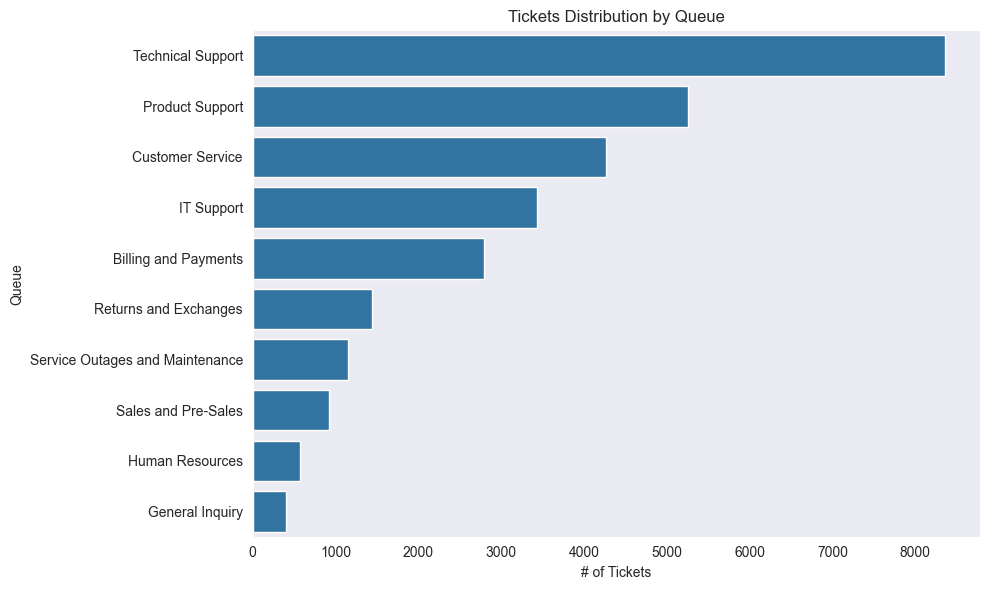

                                 # of Tickets  Percentage of Total (%)
queue                                                                 
Technical Support                        8362                    29.25
Product Support                          5252                    18.37
Customer Service                         4268                    14.93
IT Support                               3433                    12.01
Billing and Payments                     2788                     9.75
Returns and Exchanges                    1437                     5.03
Service Outages and Maintenance          1148                     4.02
Sales and Pre-Sales                       918                     3.21
Human Resources                           576                     2.01
General Inquiry                           405                     1.42


In [18]:
# Plot the distribution of tickets by queue
plot_distribution_with_table(df=raw_data, x='Tickets', y='queue')

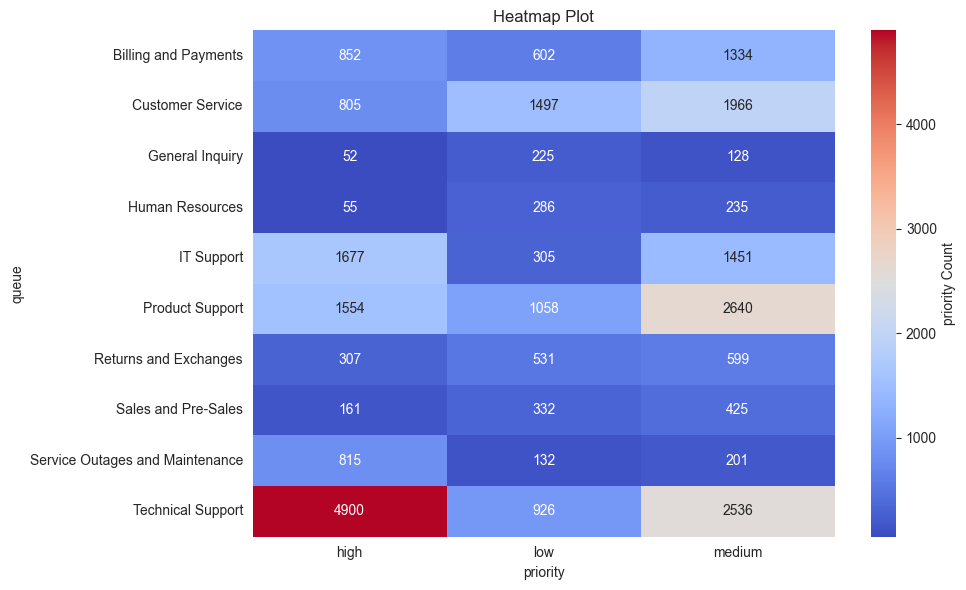

In [20]:
#let's look at the distribution of priority levels across queues
plot_queue_heatmap(raw_data, x='priority', y='queue')

I'm curious how much the following queues overlap:
- Technical Support, IT Support
- Customer Service, Returns & Exchanges, Billing & Payments

#### 2. Text Feature Exploration
 - Subject & Body Length: Are longer emails in certain queues?
    - Histogram of word counts per queue
- Top Keywords: What words or phrases are common for each queue
    - Table showing most common words or phrases

In [ ]:
# Plot text length for each queue
plot_text_length_by_queue(english_data, text_col='analysis_text', 
                          queue_col='queue', title='Text Length by Queue\n')

In [ ]:
top_words = top_keywords_per_queue(english_data, text_col='subject', queue_col='queue', method='tfidf', top_n=10)
display(top_words)

In [ ]:

# how does merging change the distribution
raw_data['updated_queue'] = raw_data['queue'].replace({
    'Technical Support': 'Technical & IT Support',
    'IT Support': 'Technical & IT Support',
    'Customer Service': 'Customer Service, Billing & Returns',
    'Billing and Payments': 'Customer Service, Billing & Returns',
    'Returns and Exchanges': 'Customer Service, Billing & Returns',
    'Product Support': 'Product Support & Sales',
    'Sales and Pre-Sales': 'Product Support & Sales',
})

plot_distribution_with_table(df=raw_data, x='Tickets', y='updated_queue', title='Updated Queue Distribution')

##### Takeaways from the Distribution plots above
1. Technical Support and IT Support dominate ticket volumne they combine for more than 40% of all tickets. This could be reflective of complex products, frequent bugs, gap in resources, ineffiecient internal processes or infrastructure issues. This may also be a place where automation is most valueable.
2. It may make sense to combine queues for example:
   - Technical Support & IT Support
   - Customer Service, Returns & Exchanges, Billing & Payment 
   - Product Support, Sales & Pre-Sales
3. General Inquiry is possibly a catch all queue when agents are unsure where to assign a ticket
4. The majority of Technical & IT Support tickets are `high` priority tickets with an addtional 3.9k `medium` tickets. I'm wondering if this queue is plagued by outages, bugs or other issues disrupting the business.
5. Customer, Billing & Returns are primarily `medium` tickets
6. Service Outages and Maintenance is dominated by `high` tickets, which is expected behavior.

#### 2. Language Insights
 - Language Distribution: Bar Chart showing counts by language
    - This will inform which embedding models need to be downloaded
- Language vs. Queue Crosstab: Heatmap of language Level by queue
    - Is multilingual support spread across queues or concentrated in one area



In [ ]:
# Plot the distribution of tickets by language
plot_distribution_with_table(df=raw_data, x='Tickets', y='detected_language', title='Language Distribution')

In [ ]:
plot_queue_heatmap(raw_data, x='detected_language', 
                   y='updated_queue', 
                   title='Updated Queue detected_language Distribution')

##### Takeaway from the language distribution plots
1. The support system is overwhelmingly English-dominant.
   - 99% of the tickets are English or German
   - 68.81% of tickets are written in English (en), with German (de) comprising the remaining major share at 31.11%.
   - All other detected languages (e.g., Spanish, Italian, French) collectively account for less than 0.1% of tickets each, making them statistically insignificant in volume.
   - The German records will be dropped from the dataset since we've run into resource contraints with getting those records translated to english.

#### 3. Ticket Type and Business Type Patterns
 - Type Frequency by Queue: 
    - Are incidents more common in “Technical Support” while “Requests” are in “HR”?
    - Heatmap to check if certain types fall heavily into specific queues.

In [ ]:
plot_queue_heatmap(english_data, x='type', y='queue')
plot_queue_heatmap(english_data, x='type', y='updated_queue')